In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [33]:
# import and clean the data

# chrome data
df_chrome = pd.read_csv("CB_chrome_cleaned.csv")
df_chrome = df_chrome.rename(columns={"visit_date" : "date", "visit_time": "time"})
df_chrome["date"] = pd.to_datetime(df_chrome["date"])
df_chrome = df_chrome.drop("Unnamed: 0", axis=1)

def get_first_and_last_visits(df):
    # find first and last visited websites per date
    first_visits = df.loc[df.groupby("date")["time"].idxmin()]
    last_visits = df.loc[df.groupby("date")["time"].idxmax()]

    # select relevant columns
    first_visits = first_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_first",
        "url": "url_first",
        "title": "title_first"
    })
    
    last_visits = last_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_last",
        "url": "url_last",
        "title": "title_last"
    })

    # merge both DataFrames on visit_date to get one row per date
    visit_summary = pd.merge(first_visits, last_visits, on="date")
    return visit_summary

df_chrome = get_first_and_last_visits(df_chrome)

# sleep data
df_sleep = pd.read_csv("cheryl_sleep_data.csv")
df_sleep = df_sleep.drop("Unnamed: 0", axis=1)
df_sleep = df_sleep.rename(columns={"Date": "date"})
df_sleep["date"] = pd.to_datetime(df_sleep["date"])
df_sleep["sleep_start"] = pd.to_datetime(df_sleep["sleep_start"])
df_sleep["sleep_end"] = pd.to_datetime(df_sleep["sleep_end"])
df_sleep["sleep_start_date"] = df_sleep["sleep_start"].dt.date
df_sleep["sleep_start_time"] = df_sleep["sleep_start"].dt.strftime("%H:%M:%S")
df_sleep["sleep_end date"] = df_sleep["sleep_end"].dt.date
df_sleep["sleep_end_time"] = df_sleep["sleep_end"].dt.strftime("%H:%M:%S")
df_sleep = df_sleep.drop(columns=["sleep_start", "sleep_end"])
df_sleep["date"] = df_sleep["sleep_start_date"]
df_sleep["date"] = pd.to_datetime(df_sleep["sleep_start_date"]) # made the date the sleep start date so you can compare visit_time_last with sleep start time, can compare sleep end time with visit_time_first of the next date

# merge the two dataframes
df = pd.merge(df_chrome, df_sleep, on="date", how="left")

# filter for time between jan 1 to feb 17
start_date = "2025-01-01"
end_date = "2025-02-17"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

df.head()

,date,visit_time_first,url_first,title_first,visit_time_last,url_last,title_last,total_sleep_hours,sleep_start_date,sleep_start_time,sleep_end date,sleep_end_time
34,2025-01-01,02:05:20,https://www.google.com/search?q=dsw&rlz=1C1ONG...,dsw - Google Search,22:56:56,https://www.amazon.com/s/ref=nb_sb_noss_2?url=...,Amazon.com : daisque,8.258333,2025-01-01,02:04:45,2025-01-01,10:30:15
35,2025-01-02,01:46:11,https://www.when2meet.com/?28134141-GcoK8,Club Figure Skating Spring 2024 Off Ice - When...,02:52:13,https://www.amazon.com/s?crid=1WQFLCYQMS1FY&i=...,Amazon.com : rice mask,11.283333,2025-01-02,01:25:02,2025-01-02,16:03:02
36,2025-01-03,01:56:00,https://www.amazon.com/s?crid=2ZM9BIE3J8XA8&i=...,Amazon.com : canmake,02:14:16,https://www.popflexactive.com/collections/perf...,Perfect Plane Pants - Black – POPFLEX®,7.325000,2025-01-03,02:04:16,2025-01-03,09:45:16
37,2025-01-04,00:58:56,https://mandrillapp.com/track/click/30837889/b...,My Team Shop,02:50:25,https://bsnteamsports.com/shop/2rkrRzKBQS/myte...,My Team Shop,7.983333,2025-01-04,02:30:17,2025-01-04,16:18:02
38,2025-01-05,00:11:47,https://www.netflix.com/browse,Home - Netflix,23:22:58,https://discussions.apple.com/thread/254776692,does an air tag interfere with credit car… - A...,5.775000,2025-01-05,02:20:19,2025-01-05,10:14:49


In [38]:
# keyword analysis
# tally up keywords
keywords = ["uva", "canvas", "eqk9vb", "drive"]

tally_data = []
last_time_per_date = {}

for _, row in df.iterrows():
    row_tally = {"date": row["date"], "total_count": 0}
    
    # Count occurrences of each keyword
    for keyword in keywords:
        count = sum(row.astype(str).str.contains(keyword, case=False, na=False))
        row_tally[keyword] = count
        row_tally["total_count"] += count

    if row["date"] not in last_time_per_date:
        last_time_per_date[row["date"]] = row["visit_time"]
    else:
        if row["visit_time"] > last_time_per_date[row["date"]]:
            last_time_per_date[row["date"]] = row["visit_time"]
    
    tally_data.append(row_tally)

tally_df = pd.DataFrame(tally_data)
summary_df = tally_df.groupby("date", as_index=False).sum()
summary_df["last_time"] = summary_df["date"].map(last_time_per_date)

KeyError: 'visit_time'

In [34]:
# summary of information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 34 to 77
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               44 non-null     datetime64[ns]
 1   visit_time_first   44 non-null     object        
 2   url_first          44 non-null     object        
 3   title_first        43 non-null     object        
 4   visit_time_last    44 non-null     object        
 5   url_last           44 non-null     object        
 6   title_last         44 non-null     object        
 7   total_sleep_hours  39 non-null     float64       
 8   sleep_start_date   39 non-null     object        
 9   sleep_start_time   39 non-null     object        
 10  sleep_end date     39 non-null     object        
 11  sleep_end_time     39 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 4.5+ KB


In [35]:
# some statistics about the dataset
df.describe()

,date,total_sleep_hours
count,44,39.000000
mean,2025-01-23 13:05:27.272727296,7.482692
min,2025-01-01 00:00:00,4.525000
25%,2025-01-11 18:00:00,6.400000
50%,2025-01-23 12:00:00,7.575000
75%,2025-02-04 06:00:00,8.329167
max,2025-02-14 00:00:00,11.283333
std,NaN,1.368131


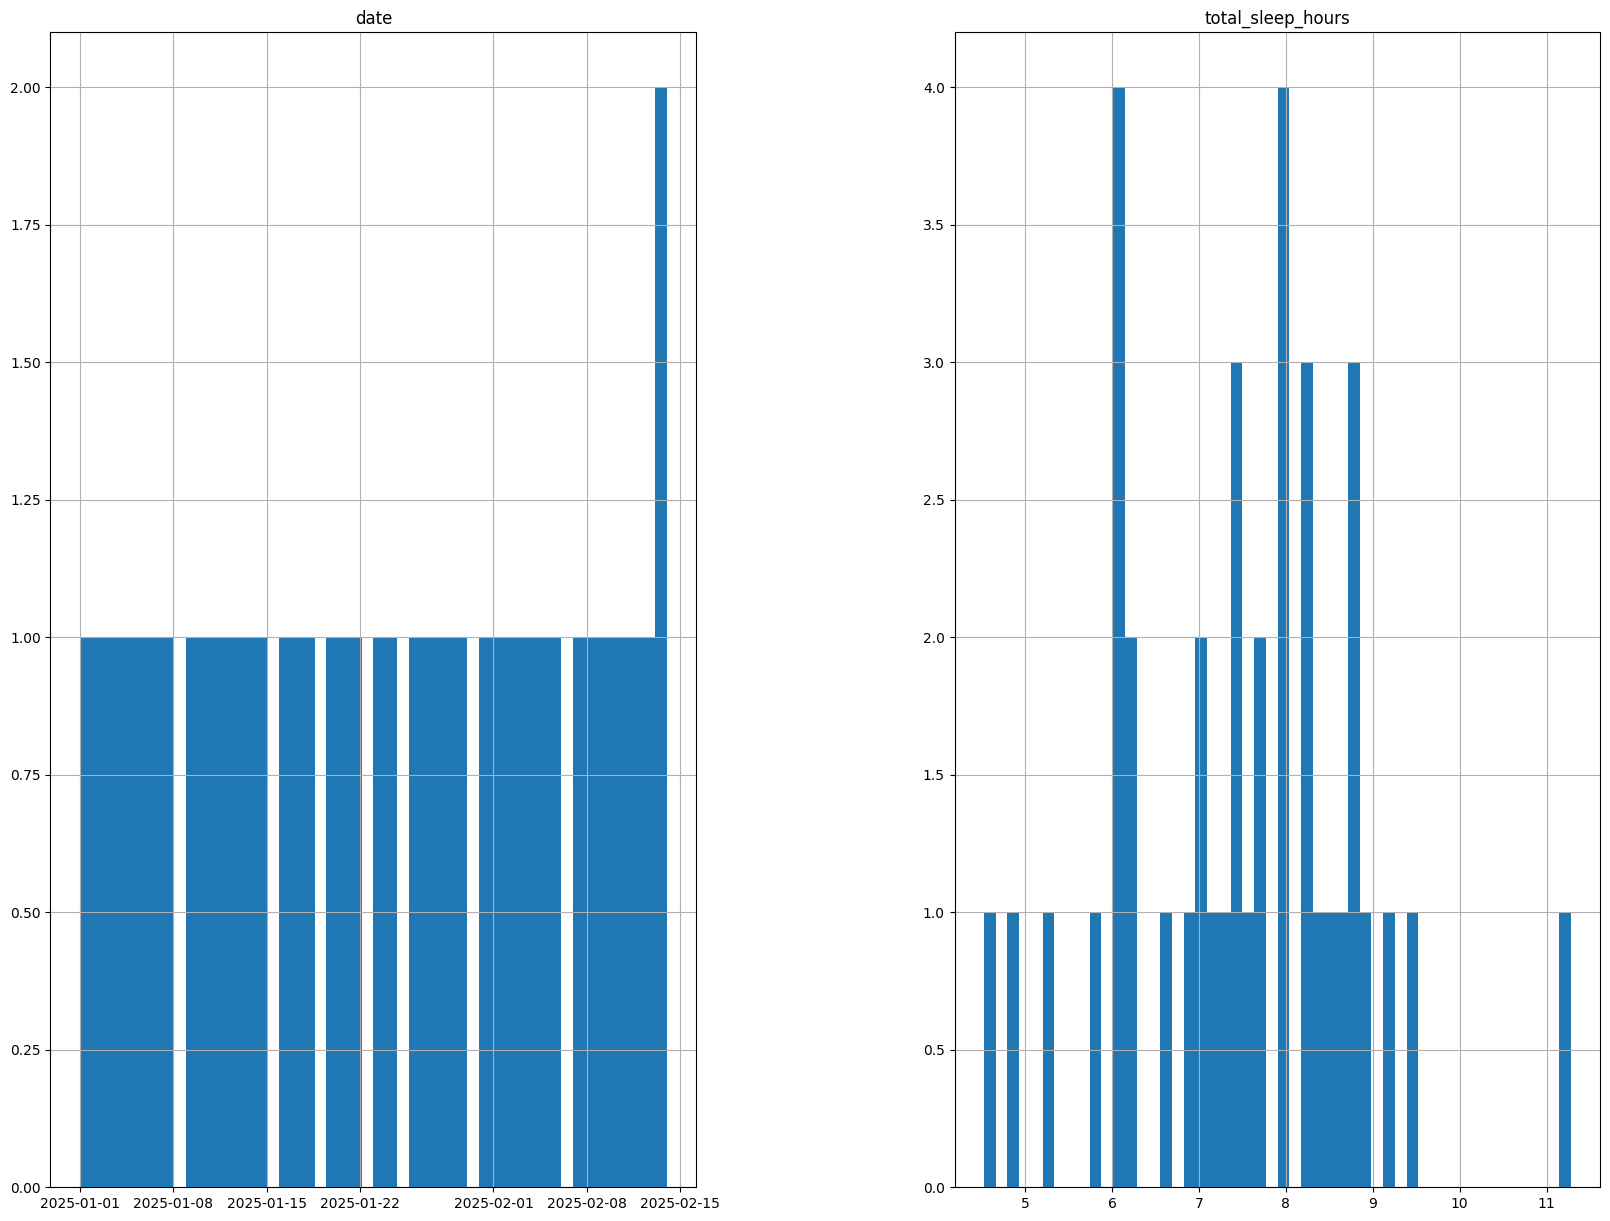

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(bins=50, figsize=(20, 15))
plt.subplots_adjust(wspace=0.4,hspace=0.6)
plt.show()

In [16]:
df = pd.read_csv('cheryl_data.csv')
df.head()

,Unnamed: 0,date,total_sleep_hours,sleep_start,sleep_end,total_count,uva,canvas,eqk9vb,drive,last_time,chrome_visit_time_first,chrome_url_first,chrome_title_first,chrome_visit_time_last,chrome_url_last,chrome_title_last,day_of_week
0,0,2025-01-01,8.258333,2025-01-01 02:04:45-05:00,2025-01-01 10:30:15-05:00,43,28,0,15,0,2025-02-23 22:56:56,02:05:20,https://www.google.com/search?q=dsw&rlz=1C1ONG...,dsw - Google Search,22:56:56,https://www.amazon.com/s/ref=nb_sb_noss_2?url=...,Amazon.com : daisque,Wednesday
1,1,2025-01-02,11.283333,2025-01-02 01:25:02-05:00,2025-01-02 16:03:02-05:00,0,0,0,0,0,2025-02-23 02:52:13,01:46:11,https://www.when2meet.com/?28134141-GcoK8,Club Figure Skating Spring 2024 Off Ice - When...,02:52:13,https://www.amazon.com/s?crid=1WQFLCYQMS1FY&i=...,Amazon.com : rice mask,Thursday
2,2,2025-01-03,7.325000,2025-01-03 02:04:16-05:00,2025-01-03 09:45:16-05:00,1,1,0,0,0,2025-02-23 02:14:16,01:56:00,https://www.amazon.com/s?crid=2ZM9BIE3J8XA8&i=...,Amazon.com : canmake,02:14:16,https://www.popflexactive.com/collections/perf...,Perfect Plane Pants - Black – POPFLEX®,Friday
3,3,2025-01-04,7.983333,2025-01-04 02:30:17-05:00,2025-01-04 16:18:02-05:00,0,0,0,0,0,2025-02-23 02:50:25,00:58:56,https://mandrillapp.com/track/click/30837889/b...,My Team Shop,02:50:25,https://bsnteamsports.com/shop/2rkrRzKBQS/myte...,My Team Shop,Saturday
4,4,2025-01-05,5.775000,2025-01-05 02:20:19-05:00,2025-01-05 10:14:49-05:00,37,21,0,10,6,2025-02-23 23:22:58,00:11:47,https://www.netflix.com/browse,Home - Netflix,23:22:58,https://discussions.apple.com/thread/254776692,does an air tag interfere with credit car… - A...,Sunday


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               43 non-null     int64  
 1   date                     43 non-null     object 
 2   total_sleep_hours        38 non-null     float64
 3   sleep_start              38 non-null     object 
 4   sleep_end                38 non-null     object 
 5   total_count              43 non-null     int64  
 6   uva                      43 non-null     int64  
 7   canvas                   43 non-null     int64  
 8   eqk9vb                   43 non-null     int64  
 9   drive                    43 non-null     int64  
 10  last_time                43 non-null     object 
 11  chrome_visit_time_first  43 non-null     object 
 12  chrome_url_first         43 non-null     object 
 13  chrome_title_first       42 non-null     object 
 14  chrome_visit_time_last   43 

In [17]:
df = df.drop(["Unnamed: 0", "date", "chrome_url_first", "chrome_title_first", "chrome_url_last", "chrome_title_last"], axis=1)
df["sleep_start"] = pd.to_datetime(df["sleep_start"])
df['sleep_start_hour'] = (
    df['sleep_start'].dt.hour +
    df['sleep_start'].dt.minute / 60.0
)
df["sleep_end"] = pd.to_datetime(df["sleep_end"])
df['sleep_end_hour'] = (
    df['sleep_end'].dt.hour +
    df['sleep_end'].dt.minute / 60.0
)
df["last_time"] = pd.to_datetime(df["last_time"])
df['last_time_hour'] = (
    df['last_time'].dt.hour +
    df['last_time'].dt.minute / 60.0
)
df["chrome_visit_time_first"] = pd.to_datetime(df["chrome_visit_time_first"])
df['chrome_visit_time_first_hour'] = (
    df['chrome_visit_time_first'].dt.hour +
    df['chrome_visit_time_first'].dt.minute / 60.0
)
df["chrome_visit_time_last"] = pd.to_datetime(df["chrome_visit_time_last"])
df['chrome_visit_time_last_hour'] = (
    df['chrome_visit_time_last'].dt.hour +
    df['chrome_visit_time_last'].dt.minute / 60.0
)
df = df.drop(["sleep_start", "sleep_end", "last_time", "chrome_visit_time_first", "chrome_visit_time_last"], axis=1)
df.head()

C:\Users\janic\AppData\Local\Temp\ipykernel_31752\2042299694.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["chrome_visit_time_first"] = pd.to_datetime(df["chrome_visit_time_first"])
C:\Users\janic\AppData\Local\Temp\ipykernel_31752\2042299694.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["chrome_visit_time_last"] = pd.to_datetime(df["chrome_visit_time_last"])


,total_sleep_hours,total_count,uva,canvas,eqk9vb,drive,day_of_week,sleep_start_hour,sleep_end_hour,last_time_hour,chrome_visit_time_first_hour,chrome_visit_time_last_hour
0,8.258333,43,28,0,15,0,Wednesday,2.066667,10.500000,22.933333,2.083333,22.933333
1,11.283333,0,0,0,0,0,Thursday,1.416667,16.050000,2.866667,1.766667,2.866667
2,7.325000,1,1,0,0,0,Friday,2.066667,9.750000,2.233333,1.933333,2.233333
3,7.983333,0,0,0,0,0,Saturday,2.500000,16.300000,2.833333,0.966667,2.833333
4,5.775000,37,21,0,10,6,Sunday,2.333333,10.233333,23.366667,0.183333,23.366667


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total_sleep_hours             38 non-null     float64
 1   total_count                   43 non-null     int64  
 2   uva                           43 non-null     int64  
 3   canvas                        43 non-null     int64  
 4   eqk9vb                        43 non-null     int64  
 5   drive                         43 non-null     int64  
 6   day_of_week                   43 non-null     object 
 7   sleep_start_hour              38 non-null     float64
 8   sleep_end_hour                38 non-null     float64
 9   last_time_hour                43 non-null     float64
 10  chrome_visit_time_first_hour  43 non-null     float64
 11  chrome_visit_time_last_hour   43 non-null     float64
dtypes: float64(6), int64(5), object(1)
memory usage: 4.2+ KB


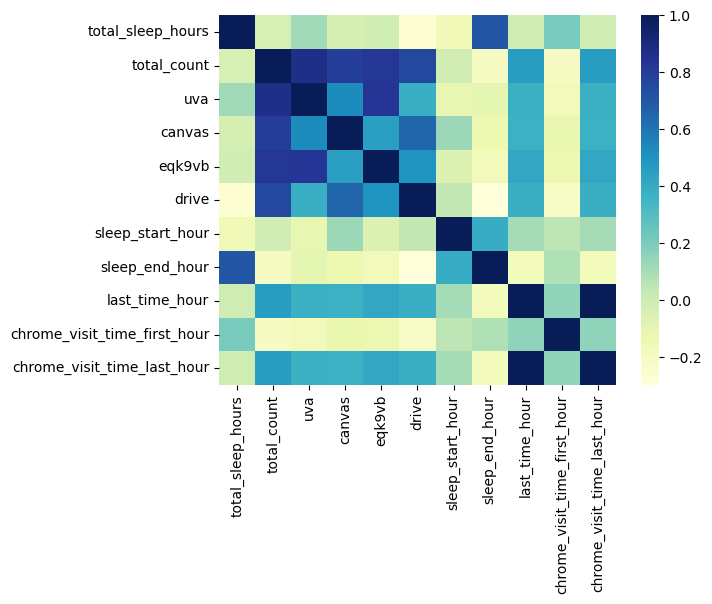

In [19]:
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

corr_matrix = df.corr(numeric_only=True)
corr_matrix.shape

corr_matrix["total_sleep_hours"].sort_values(ascending=False)

sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.show()

In [26]:
df1 = df[df.isna().any(axis=1)]
len(df1)
df1.head()

,total_sleep_hours,total_count,uva,canvas,eqk9vb,drive,day_of_week,sleep_start_hour,sleep_end_hour,last_time_hour,chrome_visit_time_first_hour,chrome_visit_time_last_hour
18,NaN,202,104,28,16,54,Monday,NaN,NaN,22.266667,0.083333,22.266667
26,NaN,218,49,53,34,82,Wednesday,NaN,NaN,23.500000,12.516667,23.500000
27,NaN,158,68,39,9,42,Thursday,NaN,NaN,22.983333,0.383333,22.983333
28,NaN,101,49,5,16,31,Friday,NaN,NaN,21.100000,2.633333,21.100000
29,NaN,62,18,20,0,24,Saturday,NaN,NaN,22.750000,17.200000,22.750000


In [27]:
df_x = df.drop("total_sleep_hours", axis=1)
df_y = df["total_sleep_hours"].copy()

from sklearn.model_selection import train_test_split
x_train, xtest, y_train, ytest = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

housing_prep = x_train
housing_labels = y_train
test_labels = ytest
housing_num = housing_prep.select_dtypes(include=np.number)
housing_cat = housing_prep.select_dtypes(include="object")

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_attribs = housing_num.columns.tolist()
cat_attribs = housing_cat.columns.tolist()

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

housing_tr = full_pipeline.fit_transform(housing_prep)
housing_test = full_pipeline.transform(xtest)

In [29]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

lin_reg = LinearRegression()
lin_reg.fit(housing_tr, housing_labels)

housing_predictions = lin_reg.predict(housing_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f"RMSE: {lin_rmse}, MAE: {lin_mae}")

ValueError: Input y contains NaN.

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_tr, housing_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_tr, housing_labels)

housing_predictions = tree_reg.predict(housing_tr)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f"RMSE: {tree_rmse}, MAE: {tree_mae}")

In [ ]:
scores = cross_val_score(tree_reg, housing_tr, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_tr, housing_labels)

housing_predictions = forest_reg.predict(housing_tr)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f"RMSE: {forest_rmse}, MAE: {forest_mae}")

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_tr, housing_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)